In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

%run ../load_magic/dataframes.py
from storage import Storage
from datetime import datetime

s = Storage()

In [4]:

root_dir = r'C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\data\csv'
# !start %windir%\\explorer.exe "{root_dir}"
columns_list = ['Date_Time', 'mG', 'V_m', 'mW_m2', 'mW_cm2', 'pW_cm2', 'Possible_Source']
gq_emf390_df = pd.DataFrame([], columns=columns_list)
for sub_directory, directories_list, files_list in os.walk(root_dir):
    for file_name in files_list:
        if file_name.startswith('emfhistory_') and file_name.endswith('.csv'):
            csv_path = os.path.join(sub_directory, file_name)
            df = pd.read_csv(os.path.abspath(csv_path), sep=',', skiprows=[0, 1], encoding=s.encoding_type)
            df.columns = columns_list
            df.Date_Time = pd.to_datetime(df.Date_Time)
            gq_emf390_df = pd.concat([gq_emf390_df, df], join='inner')
gq_emf390_df = gq_emf390_df.drop_duplicates(subset='Date_Time')
gq_emf390_df.Date_Time = pd.to_datetime(gq_emf390_df.Date_Time)
gq_emf390_df = gq_emf390_df.set_index('Date_Time')

In [29]:

# Extract data from Mimi's journal
workbook_name = 'mimiz_symptoms_journal'
try:
    xlsx_folder = os.path.join(s.data_folder, 'xlsx')
    file_path = os.path.join(xlsx_folder, f'{workbook_name}.xlsx')
    print(os.path.abspath(file_path))
    mimiz_symptoms_journal_df = pd.read_excel(file_path).fillna(0)
except Exception as e:
    print(f'{e.__class__.__name__} error: {str(e).strip()}')
    if s.csv_exists(workbook_name, folder_path=s.data_csv_folder):
        mimiz_symptoms_journal_df = s.load_csv(workbook_name).fillna(0)
def f(row_series):
    year = int(row_series.year)
    month = int(row_series.month)
    day = int(row_series.day)
    hour = int(row_series.hour)
    minute = int(row_series.minute)
    # print(year, month, day, hour, minute)
    datetime_obj = datetime(year, month, day, hour=hour, minute=minute)
    
    return datetime_obj
mask_series = (mimiz_symptoms_journal_df.year > 0)
mimiz_symptoms_journal_df.loc[mask_series, 'datetime'] = mimiz_symptoms_journal_df[mask_series].apply(f, axis='columns')

C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\data\xlsx\mimiz_symptoms_journal.xlsx


In [31]:

mask_series = (mimiz_symptoms_journal_df.year > 0)
mimiz_symptoms_journal_df[mask_series].sort_values('datetime')

,year,month,day,hour,minute,note,comments,datetime
0,2022.0,6.0,20.0,0.0,0.0,woke up two times to use bathroom. Restless bo...,0,2022-06-20 00:00:00
29,2022.0,6.0,20.0,0.0,0.0,migraine while in car,0,2022-06-20 00:00:00
28,2022.0,6.0,20.0,0.0,0.0,right elbow hurts at times when used,0,2022-06-20 00:00:00
27,2022.0,6.0,20.0,0.0,0.0,left hand hurts,0,2022-06-20 00:00:00
26,2022.0,6.0,20.0,0.0,0.0,catching a deep breath here and there,0,2022-06-20 00:00:00
...,...,...,...,...,...,...,...,...
194,2022.0,7.0,16.0,0.0,0.0,woke up with neckache on right,0,2022-07-16 00:00:00
202,2022.0,7.0,16.0,11.0,50.0,getting ready to go shopping,0,2022-07-16 11:50:00
203,2022.0,7.0,16.0,12.0,43.0,going shopping; phone on,0,2022-07-16 12:43:00
205,2022.0,7.0,16.0,19.0,0.0,home again,0,2022-07-16 19:00:00


In [34]:

# V/m is electrical
# mW/m2 is radio
journal_min = datetime(2022, 7, 16, hour=0, minute=0)
journal_max = mimiz_symptoms_journal_df.datetime.max()
mask_series = (gq_emf390_df.index >= journal_min)
mask_series = mask_series & (gq_emf390_df.index <= journal_max)
# mask_series = mask_series & (gq_emf390_df.Possible_Source == 'Mixed')
df = gq_emf390_df[mask_series].reset_index().groupby('Date_Time').sum()
x = df.index.tolist()
y = df.mW_m2.tolist()

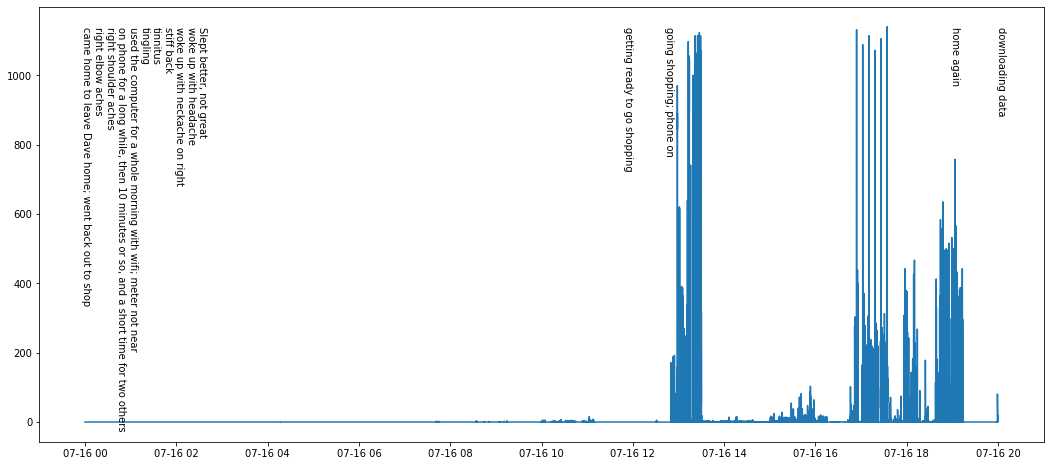

In [35]:

fig, ax = plt.subplots(figsize=(18, 8))
Line2D_obj = ax.plot(x, y)[0]
y_max = df.mW_m2.max()
def f(df):
    notes_list = df.note.tolist()
    
    return [str(note) for note in notes_list]
for datetime_obj, notes_list in mimiz_symptoms_journal_df.groupby('datetime').apply(f).iteritems():
    annotation = plt.annotate('\n'.join(notes_list), xy=(datetime_obj, y_max), rotation=-90, rotation_mode='anchor')

In [36]:

df.groupby('Possible_Source').max()

,mG,V_m,mW_m2,mW_cm2,pW_cm2
Possible_Source,,,,,
AC EF,4.7,1010.5,1113.991,0.111,1.113991e+08
Cell Tower,10.8,78.2,59.242,0.006,5.924150e+06
Mixed,22.5,1017.0,1122.603,0.112,1.122603e+08
Power Line,15.7,953.5,992.466,0.099,9.924665e+07
Smart Meter,2.4,1028.0,984.853,0.098,9.848531e+07
Static,0.0,237.2,17.543,0.002,1.754255e+06
WiFi/Phone,16.9,29.8,1140.027,0.114,1.140027e+08



----

In [ ]:

# 3:30to 6:30
mask_series = (gq_emf390_df.index >= datetime(2022, 7, 2, hour=8, minute=30))
mask_series = mask_series & (gq_emf390_df.index <= datetime(2022, 7, 2, hour=13, minute=0))
gq_emf390_df[mask_series].V_m.plot.line();

In [70]:

datetime.today()

datetime.datetime(2022, 7, 7, 18, 40, 30, 466006)

In [ ]:

gq_emf390_df.V_m.plot?

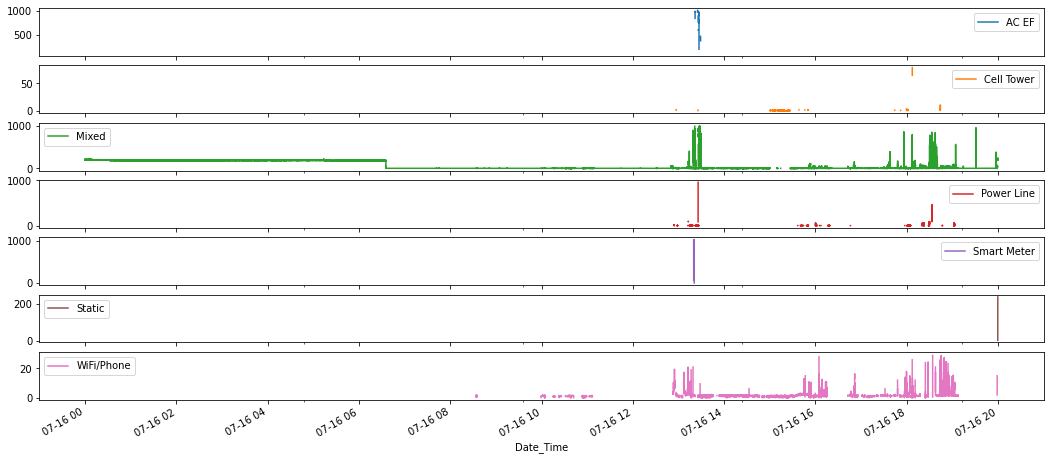

In [37]:

pd.pivot_table(df.reset_index(), index='Date_Time', columns='Possible_Source',
               values='V_m').plot(subplots=True, figsize=(18, 8),
                                  layout=(len(df.Possible_Source.unique()), 1));

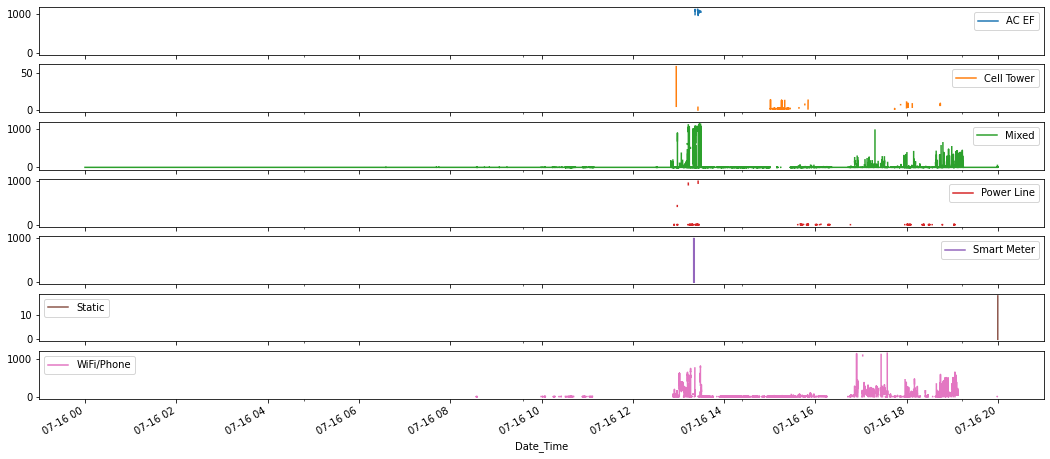

In [38]:

pd.pivot_table(df.reset_index(), index='Date_Time', columns='Possible_Source',
               values='mW_m2').plot(subplots=True, figsize=(18, 8),
                                  layout=(len(df.Possible_Source.unique()), 1));

In [ ]:

mask_series = (gq_emf390_df.index >= datetime(2022, 7, 2, hour=8, minute=30))
mask_series = mask_series & (gq_emf390_df.index <= datetime(2022, 7, 2, hour=13, minute=0))
pd.pivot_table(gq_emf390_df[mask_series].reset_index(), index='Date_Time', columns='Possible_Source',
               values='mW_m2').plot(subplots=True, figsize=(18, 8),
                                  layout=(len(gq_emf390_df.Possible_Source.unique()), 1));

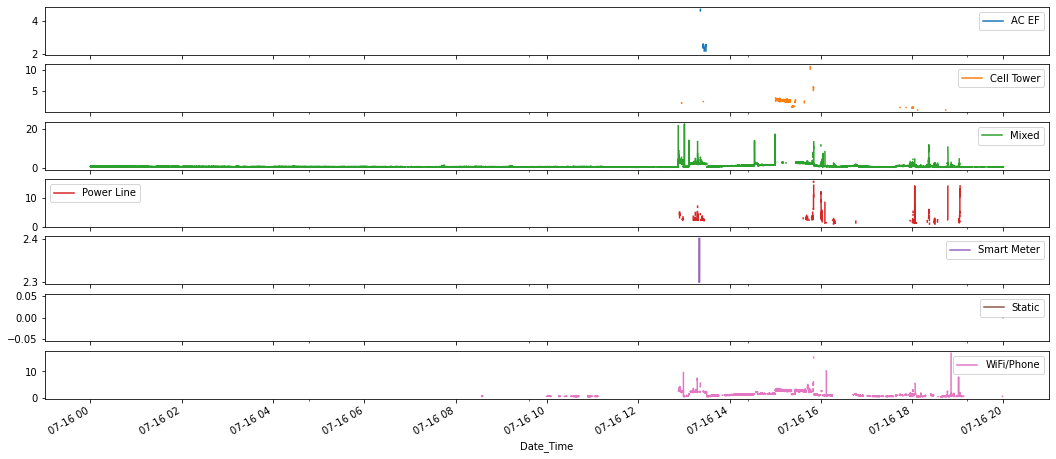

In [39]:

pd.pivot_table(df.reset_index(), index='Date_Time', columns='Possible_Source',
               values='mG').plot(subplots=True, figsize=(18, 8),
                                  layout=(len(df.Possible_Source.unique()), 1));

In [ ]:

mask_series = (gq_emf390_df.index >= datetime(2022, 7, 2, hour=8, minute=30))
mask_series = mask_series & (gq_emf390_df.index <= datetime(2022, 7, 2, hour=13, minute=0))
pd.pivot_table(gq_emf390_df[mask_series].reset_index(), index='Date_Time', columns='Possible_Source',
               values='mG').plot(subplots=True, figsize=(18, 8),
                                  layout=(len(gq_emf390_df.Possible_Source.unique()), 1));

In [17]:

mask_series = (gq_emf390_df.index >= datetime(2022, 7, 2, hour=8, minute=30))
mask_series = mask_series & (gq_emf390_df.index <= datetime(2022, 7, 2, hour=13, minute=0))
gq_emf390_df[mask_series].groupby('Possible_Source').max()

,mG,V_m,mW_m2,mW_cm2,pW_cm2
Possible_Source,,,,,
AC EF,9.7,170.2,0.012,0.000,1.152557e+03
Cell Tower,3.4,12.5,16.117,0.002,1.611719e+06
Mixed,29.0,836.0,1088.551,0.109,1.088551e+08
Power Line,21.9,99.8,515.752,0.052,5.157522e+07
Static,0.0,15.5,0.016,0.000,1.634011e+03
WiFi/Phone,51.5,26.0,685.779,0.069,6.857794e+07


In [76]:

dir(s)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'attempt_to_pickle', 'csv_exists', 'data_csv_folder', 'data_folder', 'encoding_type', 'load_csv', 'load_dataframes', 'load_object', 'pickle_exists', 'save_dataframes', 'saves_csv_folder', 'saves_folder', 'saves_pickle_folder', 'store_objects']

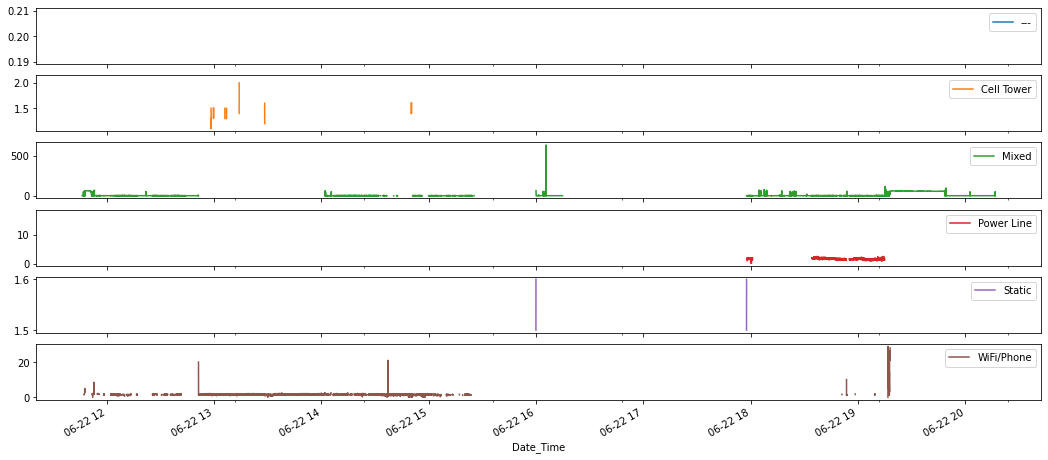

In [92]:

mask_series = (gq_emf390_df.index >= mimiz_symptoms_journal_df.index.min())
mask_series = mask_series & (gq_emf390_df.index <= mimiz_symptoms_journal_df.index.max())
pd.pivot_table(gq_emf390_df[mask_series].reset_index(), index='Date_Time', columns='Possible_Source',
               values='V_m').plot(subplots=True, figsize=(18, 8),
                                  layout=(len(gq_emf390_df[mask_series].Possible_Source.unique()), 1));

In [184]:

gq_emf390_df

,mG,V_m,mW_m2,mW_cm2,pW_cm2,Possible_Source
Date_Time,,,,,,
2022-06-22 11:46:17,0.6,1.4,0.001,0.0,75.992,Mixed
2022-06-22 11:46:18,0.7,1.6,0.001,0.0,88.036,Mixed
2022-06-22 11:46:19,0.7,1.6,0.001,0.0,88.036,Mixed
2022-06-22 11:46:20,0.7,1.6,0.001,0.0,88.036,Mixed
2022-06-22 11:46:21,0.7,1.6,0.001,0.0,88.036,Mixed
...,...,...,...,...,...,...
2022-07-09 08:07:18,0.6,1.2,0.001,0.0,75.992,Mixed
2022-07-09 08:07:19,0.6,1.2,0.001,0.0,75.992,Mixed
2022-07-09 08:07:20,0.6,1.0,0.001,0.0,75.992,Mixed


In [185]:

gq_emf390_df.index.has_duplicates

False

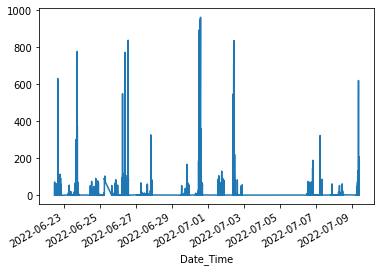

In [186]:

# V/m is electrical
gq_emf390_df.V_m.plot.line();

In [65]:

gq_emf390_df.Possible_Source.unique()

array(['Mixed', 'WiFi/Phone', 'Cell Tower', 'Static', '---', 'Power Line',
       'Smart Meter', 'AC EF'], dtype=object)

In [66]:

mask_series = (gq_emf390_df.Possible_Source == 'Smart Meter')
gq_emf390_df[mask_series]

,mG,V_m,mW_m2,mW_cm2,pW_cm2,Possible_Source
Date_Time,,,,,,
2022-06-23 14:21:57,0.6,1.0,144.745,0.014,14474514.0,Smart Meter


In [67]:

gq_emf390_df.groupby('Possible_Source').max()

,mG,V_m,mW_m2,mW_cm2,pW_cm2
Possible_Source,,,,,
---,0.0,0.2,0.001,0.000,8.199100e+01
AC EF,9.7,285.2,0.012,0.000,1.152557e+03
Cell Tower,7.9,72.4,117.571,0.012,1.175712e+07
Mixed,29.0,962.0,1105.446,0.111,1.105446e+08
Power Line,43.4,99.8,515.752,0.052,5.157522e+07
Smart Meter,0.6,1.0,144.745,0.014,1.447451e+07
Static,0.0,15.5,3.697,0.000,3.697266e+05
WiFi/Phone,51.5,72.9,1055.531,0.106,1.055531e+08


In [68]:

gq_emf390_df.groupby('Possible_Source').std()

,mG,V_m,mW_m2,mW_cm2,pW_cm2
Possible_Source,,,,,
---,NaN,NaN,NaN,NaN,NaN
AC EF,3.162654,62.860693,0.003742,0.000000,3.658298e+02
Cell Tower,1.303901,18.972756,8.718489,0.000975,8.718496e+05
Mixed,0.344054,14.898269,16.160845,0.001618,1.616086e+06
Power Line,2.402394,10.074028,8.155212,0.000822,8.155222e+05
Smart Meter,NaN,NaN,NaN,NaN,NaN
Static,0.000000,2.866890,0.754389,0.000000,7.544503e+04
WiFi/Phone,1.158923,1.950271,43.642873,0.004383,4.364289e+06


In [60]:

column_descriptions_df = get_column_descriptions(gq_emf390_df)

In [61]:

column_descriptions_df

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
0,mG,object,0,171,30,True,0.0,51.5,False
1,V_m,object,0,675,3724,True,0.0,962.0,False
2,mW_m2,object,0,1257,170,True,0.0,1105.446,False
3,mW_cm2,object,0,82,486416,True,0.0,0.111,False
4,pW_cm2,object,0,1507,26,True,0.0,110544576.0,False
5,Possible_Source,object,0,8,0,False,---,WiFi/Phone,NaN


In [ ]:

for row_index, row_series in mimiz_symptoms_journal_df.iterrows():
    datetime_obj = row_series.datetime
    note_str = row_series.note
    print(datetime_obj, note_str)

In [158]:

datetime(2022, 6, 22, hour=0, minute=0)

datetime.datetime(2022, 6, 22, 0, 0)

In [ ]:

matplotlib.text.Text?

In [139]:

[f'matplotlib.transforms.{fn}' for fn in dir(matplotlib.transforms) if not fn.startswith('_')]

['matplotlib.transforms.Affine2D', 'matplotlib.transforms.Affine2DBase', 'matplotlib.transforms.AffineBase', 'matplotlib.transforms.AffineDeltaTransform', 'matplotlib.transforms.Bbox', 'matplotlib.transforms.BboxBase', 'matplotlib.transforms.BboxTransform', 'matplotlib.transforms.BboxTransformFrom', 'matplotlib.transforms.BboxTransformTo', 'matplotlib.transforms.BboxTransformToMaxOnly', 'matplotlib.transforms.BlendedAffine2D', 'matplotlib.transforms.BlendedGenericTransform', 'matplotlib.transforms.CompositeAffine2D', 'matplotlib.transforms.CompositeGenericTransform', 'matplotlib.transforms.DEBUG', 'matplotlib.transforms.IdentityTransform', 'matplotlib.transforms.LockableBbox', 'matplotlib.transforms.Path', 'matplotlib.transforms.ScaledTranslation', 'matplotlib.transforms.Transform', 'matplotlib.transforms.TransformNode', 'matplotlib.transforms.TransformWrapper', 'matplotlib.transforms.TransformedBbox', 'matplotlib.transforms.TransformedPatchPath', 'matplotlib.transforms.TransformedPath

In [ ]:

plt.annotate?

In [119]:

gq_emf390_df.index

DatetimeIndex(['2022-06-22 11:46:17', '2022-06-22 11:46:18',
               '2022-06-22 11:46:19', '2022-06-22 11:46:20',
               '2022-06-22 11:46:21', '2022-06-22 11:46:22',
               '2022-06-22 11:46:23', '2022-06-22 11:46:24',
               '2022-06-22 11:46:25', '2022-06-22 11:46:26',
               ...
               '2022-07-06 21:43:30', '2022-07-06 21:43:31',
               '2022-07-06 21:43:32', '2022-07-06 21:43:33',
               '2022-07-06 21:43:34', '2022-07-06 21:43:35',
               '2022-07-06 21:43:36', '2022-07-06 21:43:37',
               '2022-07-06 21:43:38', '2022-07-06 21:43:39'],
              dtype='datetime64[ns]', name='Date_Time', length=513360, freq=None)